# One-county Inversion

In [1]:
import sys, os
sys.path.insert(0,'../../../src')

import numpy as np
import matplotlib.pyplot as plt
import ray

from utils import load_params
from Ypred import Ypred
from vi import adam_MLE, adam_VI
from transforms import theta_t_inv, theta_to_vec, vec_to_theta, phi_to_vec, theta_t, phi_to_phi_hat
from evaluate import evaluate_MLE, evaluate_VI
import grad_loglik

## Define parameters and plot single county case counts

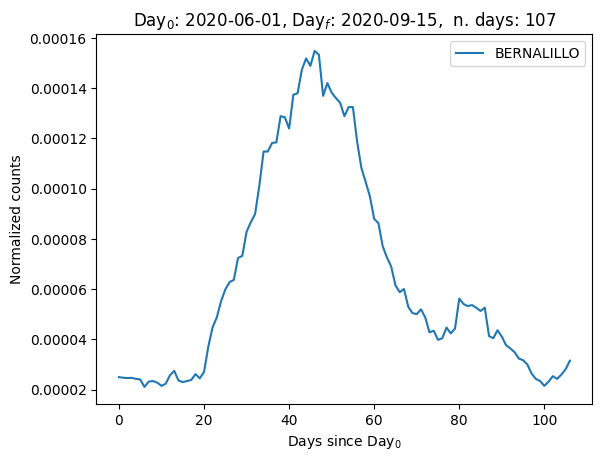

In [8]:
params = {  "counties":         ['BERNALILLO'],
            "names":            {'BERNALILLO':'B'},
            "num_cpus":         1,
            "N_mc_blocks":      28,
            "incubation_median":5.1,
            "incubation_sigma": 0.418, 
            "day0":             '2020-06-01',
            "dayf":             '2020-09-15',
            "running_avg_obs":  7,
            "forecast_day0":    '2020-09-16',
            "forecast_dayf":    '2020-10-01',
            "nquad_pred":       200,
            "nquad_grad":       200,
            "F_LN_eps":         1e-9,
            "scale_cov":        True,
          
            "MLE_max_its":      100,
            "MLE_tol":          1e-3,
            "MLE_alpha_0":      0.005,
            "MLE_log_freq":     10,
            "MLE_log_header":   'MLE_',
          
            "run_VI":           True,
            "VI_type":          'pathwise',
            "VI_max_its":       50,
            "VI_tol":           1e-3,
            "VI_alpha_0":       0.005,
            "VI_log_freq":      10,
            "VI_log_header":    'VI_',
            "VI_Ns_grad":       100,
            "VI_Ns_obj":        300,
          
            "plot_VI":          True,
            "plot_VI_nepochs":  5000,
            "plot_Ypred_pf":    True,
            "plot_fGamma_pf":   True,
            "Ns_pf":            100,
            "plot_VI_params":   True
            }
# Add additional data to dictionary needed by model
load_params(params,data_dir='../../../data/')

## Define an initial guess for model parameters to carry of MLE

/Users/whbridg/repo/outbreakdetector/src/forWyatt/vi/docs/source/notebooks/../../../src/transforms.py:18: RuntimeWarning: divide by zero encountered in log
  return log(x) - log(1-x)


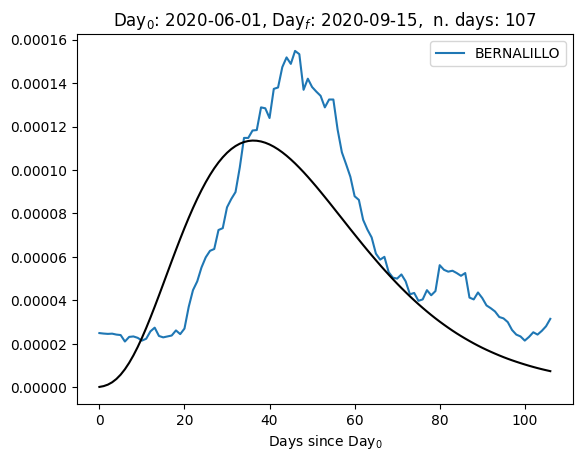

In [3]:
theta_0 = [np.array([[-9,6e-3,4.5,11] for i in range(len(params['counties']))]),np.array([1e-15,1.0,1e-3,1e-3])]
theta_hat_0 = theta_t_inv(theta_0)

plt.figure()
for i,key in enumerate(params['counties']):  
    plt.plot(params['daily_counts'][i])
Y_pred = Ypred(theta_hat_0,params)
for i in range(params['Nreg']):  
    plt.plot(Y_pred[i],color='black')
plt.legend(params['counties'])
plt.title(r'Day$_0$: {0}, Day$_f$: {1},  n. days: {2}'.format(params['day0'],params['dayf'],params['t'].shape[0]))
plt.xlabel(r'Days since Day$_0$')

params['theta_0'] = theta_0

## Define an uninformative prior

In [4]:
prior_types1 = np.array(params['Nreg']*[['none','none','none','none']])
prior_types2 = np.array(4*['none'])
params['prior_types'] = [prior_types1,prior_types2]
prior_params1 = np.zeros([params['Nreg'],4],dtype='object')
for r in range(params['Nreg']):
    prior_params1[r,0] = np.array([])
    prior_params1[r,1] = np.array([])
    prior_params1[r,2] = np.array([])
    prior_params1[r,3] = np.array([])
prior_params2 = np.zeros(4,dtype='object')
for i in range(4):
        prior_params2[i] = np.array([])
params['prior_params'] = [prior_params1,prior_params2]

## Obtain a Maximum Likelihood Estimate

It: 10 Prog: %10.0 Obj: 7.444e+02 Grad norm: 1.069e+02
Avg. grad comp. time: 0.026. Avg obj comp. time: 0.018

It: 20 Prog: %20.0 Obj: 7.498e+02 Grad norm: 1.069e+02
Avg. grad comp. time: 0.026. Avg obj comp. time: 0.015

It: 30 Prog: %30.0 Obj: 7.551e+02 Grad norm: 1.069e+02
Avg. grad comp. time: 0.026. Avg obj comp. time: 0.014

It: 40 Prog: %40.0 Obj: 7.605e+02 Grad norm: 1.069e+02
Avg. grad comp. time: 0.026. Avg obj comp. time: 0.015

It: 50 Prog: %50.0 Obj: 7.658e+02 Grad norm: 1.069e+02
Avg. grad comp. time: 0.026. Avg obj comp. time: 0.015

It: 60 Prog: %60.0 Obj: 7.712e+02 Grad norm: 1.069e+02
Avg. grad comp. time: 0.026. Avg obj comp. time: 0.015

It: 70 Prog: %70.0 Obj: 7.765e+02 Grad norm: 1.069e+02
Avg. grad comp. time: 0.026. Avg obj comp. time: 0.016

It: 80 Prog: %80.0 Obj: 7.819e+02 Grad norm: 1.069e+02
Avg. grad comp. time: 0.026. Avg obj comp. time: 0.015

It: 90 Prog: %90.0 Obj: 7.872e+02 Grad norm: 1.069e+02
Avg. grad comp. time: 0.026. Avg obj comp. time: 0.015

I

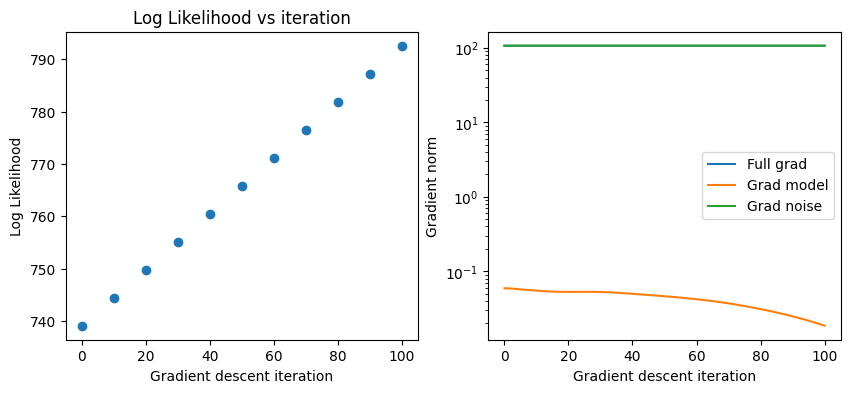

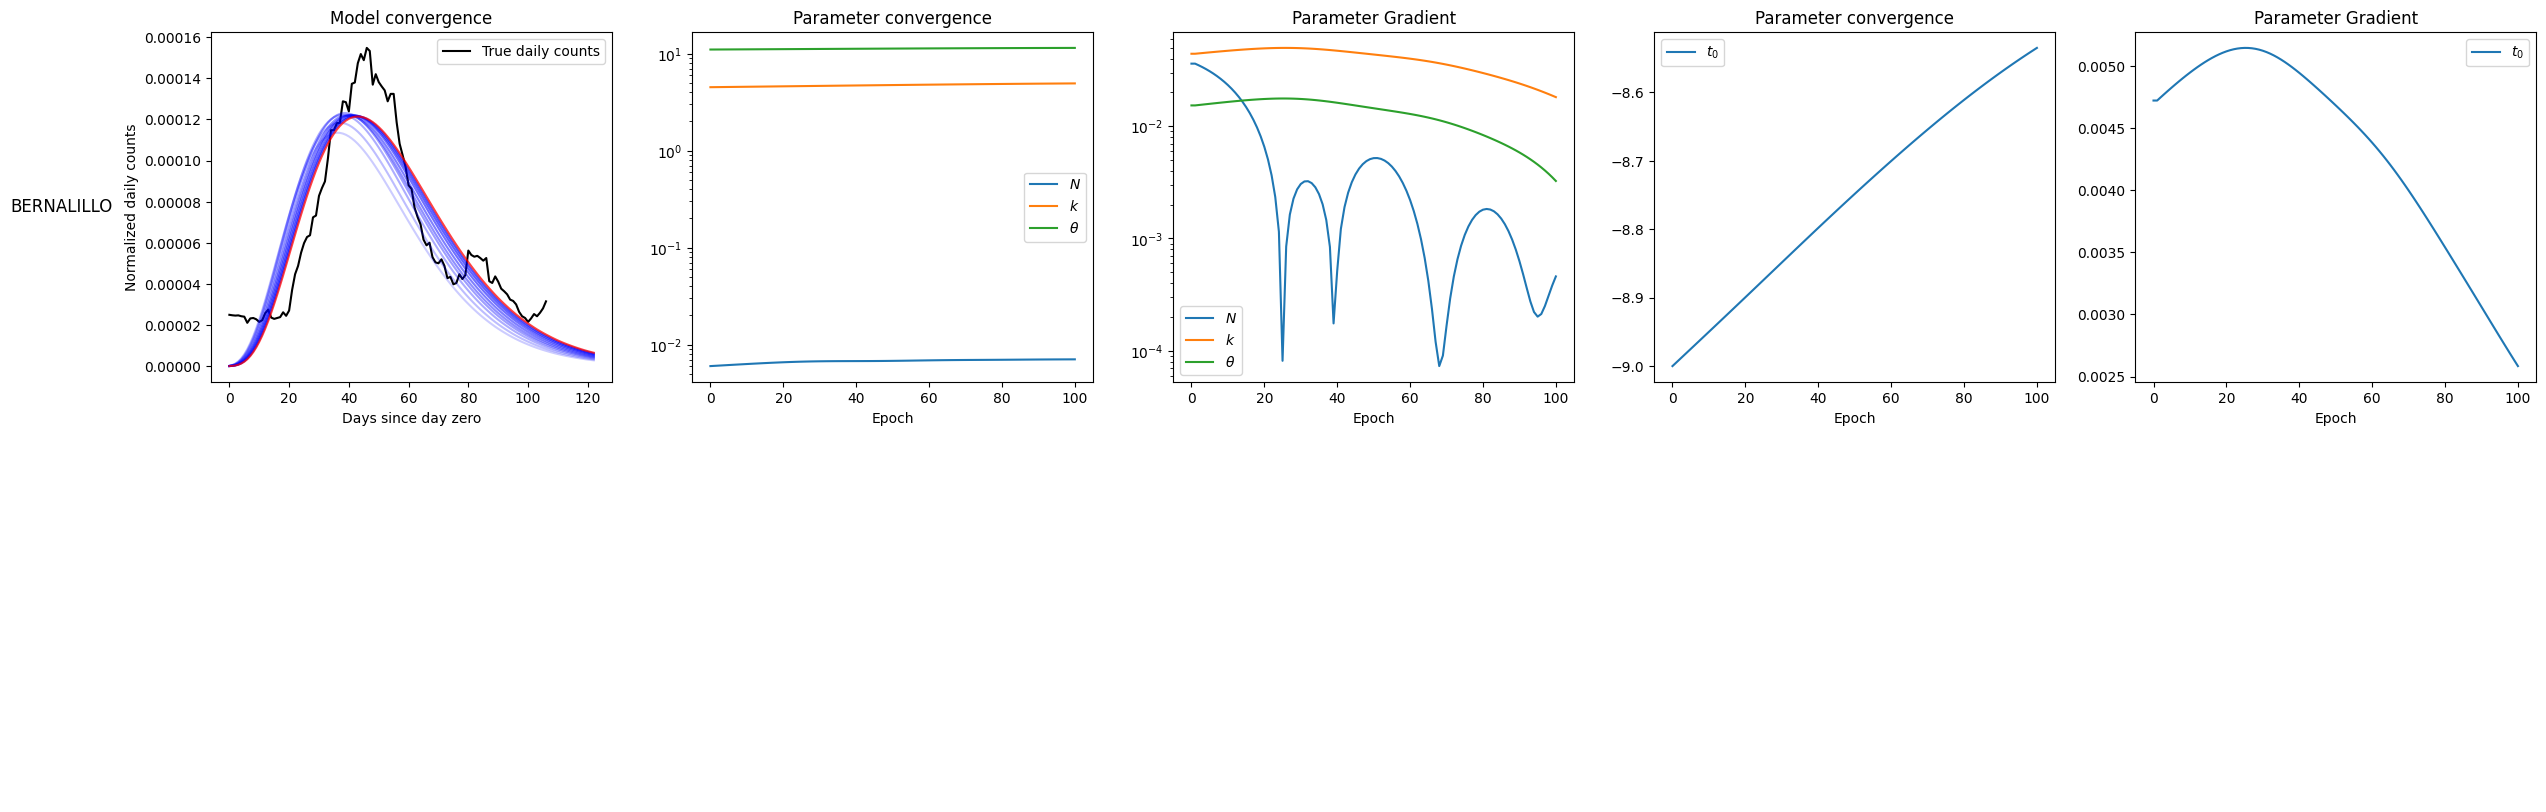

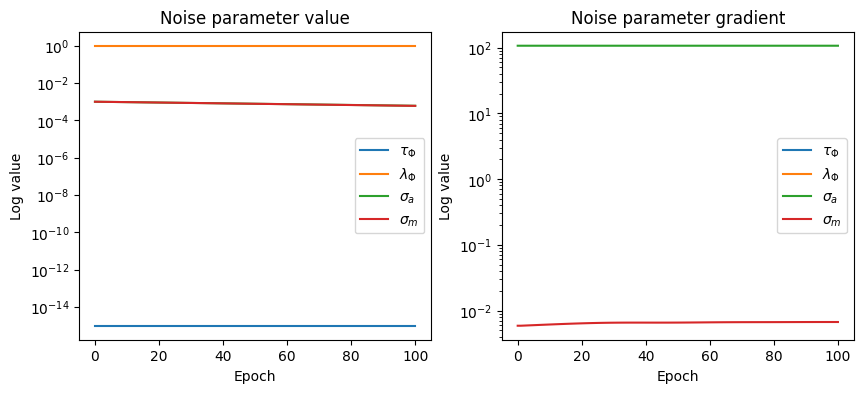

In [5]:
# Map intial condition to uncontrained representation
theta_0 = params['theta_0']
theta_hat_0 = theta_t_inv(theta_0)

# Define a learning rate schedule
def alpha_schedule(it,max_its):
    return params['MLE_alpha_0']

# MLE via Adam
theta_f,obj_hist,theta_hist, grad_norm_hist = adam_MLE( theta_to_vec(theta_hat_0),
                                                        params=params,
                                                        max_its=params['MLE_max_its'],
                                                        tol=params['MLE_tol'],
                                                        alpha_0=params['MLE_alpha_0'],
                                                        alpha_schedule=alpha_schedule,
                                                        log_freq=params['MLE_log_freq'],
                                                        log_header=params['MLE_log_header'],
                                                        grad_model=True,
                                                        grad_noise=True
                                                        )
evaluate_MLE(data_dir='',params=params)

Started VI from MLE epoch: -1
It: 10 Prog: %10.0 Obj: -7.310e+02 Grad norm: 8.984e+01
Avg. grad comp. time: 0.222. Avg obj comp. time: 0.471

It: 20 Prog: %20.0 Obj: -7.364e+02 Grad norm: 8.984e+01
Avg. grad comp. time: 0.222. Avg obj comp. time: 0.456

It: 30 Prog: %30.0 Obj: -7.418e+02 Grad norm: 8.983e+01
Avg. grad comp. time: 0.218. Avg obj comp. time: 0.447

It: 40 Prog: %40.0 Obj: -7.472e+02 Grad norm: 8.982e+01
Avg. grad comp. time: 0.217. Avg obj comp. time: 0.445

It: 50 Prog: %50.0 Obj: -7.526e+02 Grad norm: 8.981e+01
Avg. grad comp. time: 0.216. Avg obj comp. time: 0.442

It: 60 Prog: %60.0 Obj: -7.579e+02 Grad norm: 8.980e+01
Avg. grad comp. time: 0.216. Avg obj comp. time: 0.442

It: 70 Prog: %70.0 Obj: -7.633e+02 Grad norm: 8.979e+01
Avg. grad comp. time: 0.216. Avg obj comp. time: 0.444

It: 80 Prog: %80.0 Obj: -7.687e+02 Grad norm: 8.978e+01
Avg. grad comp. time: 0.216. Avg obj comp. time: 0.444

It: 90 Prog: %90.0 Obj: -7.739e+02 Grad norm: 8.977e+01
Avg. grad comp. ti

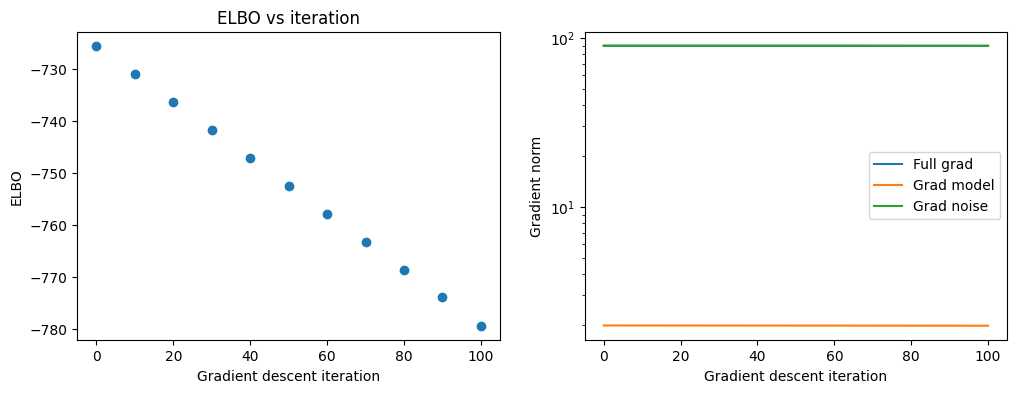

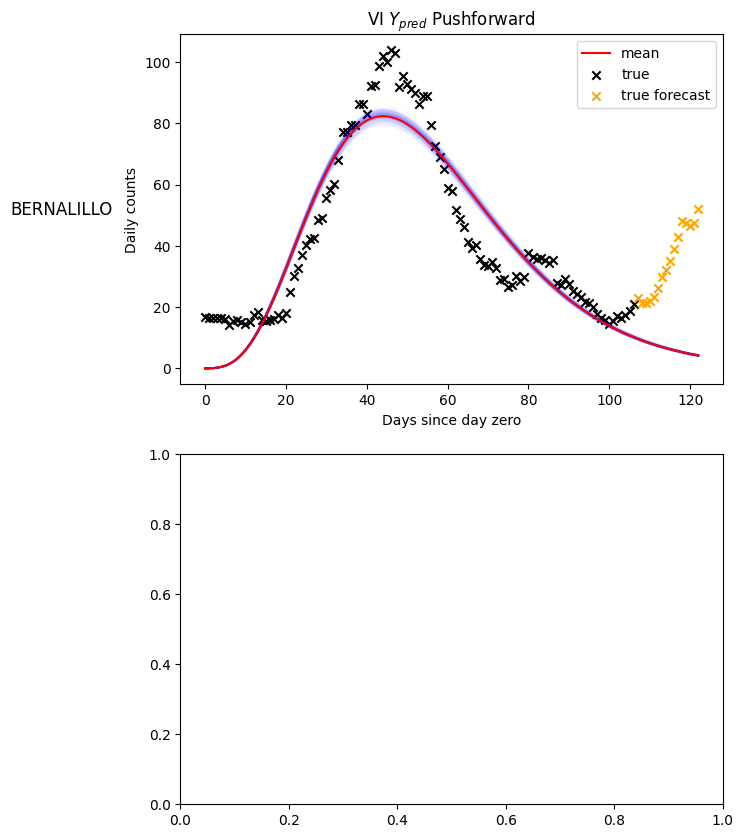

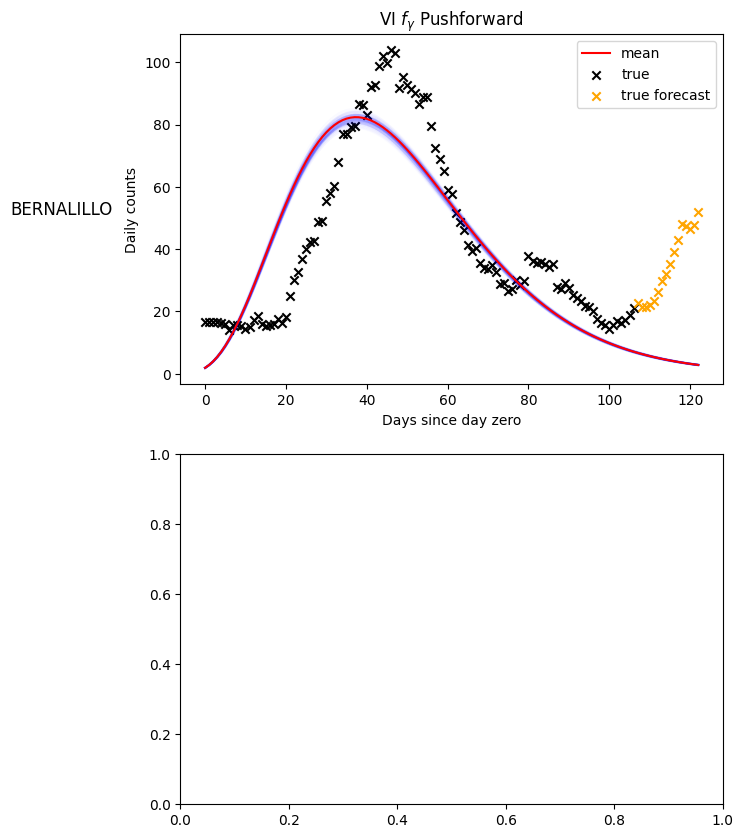

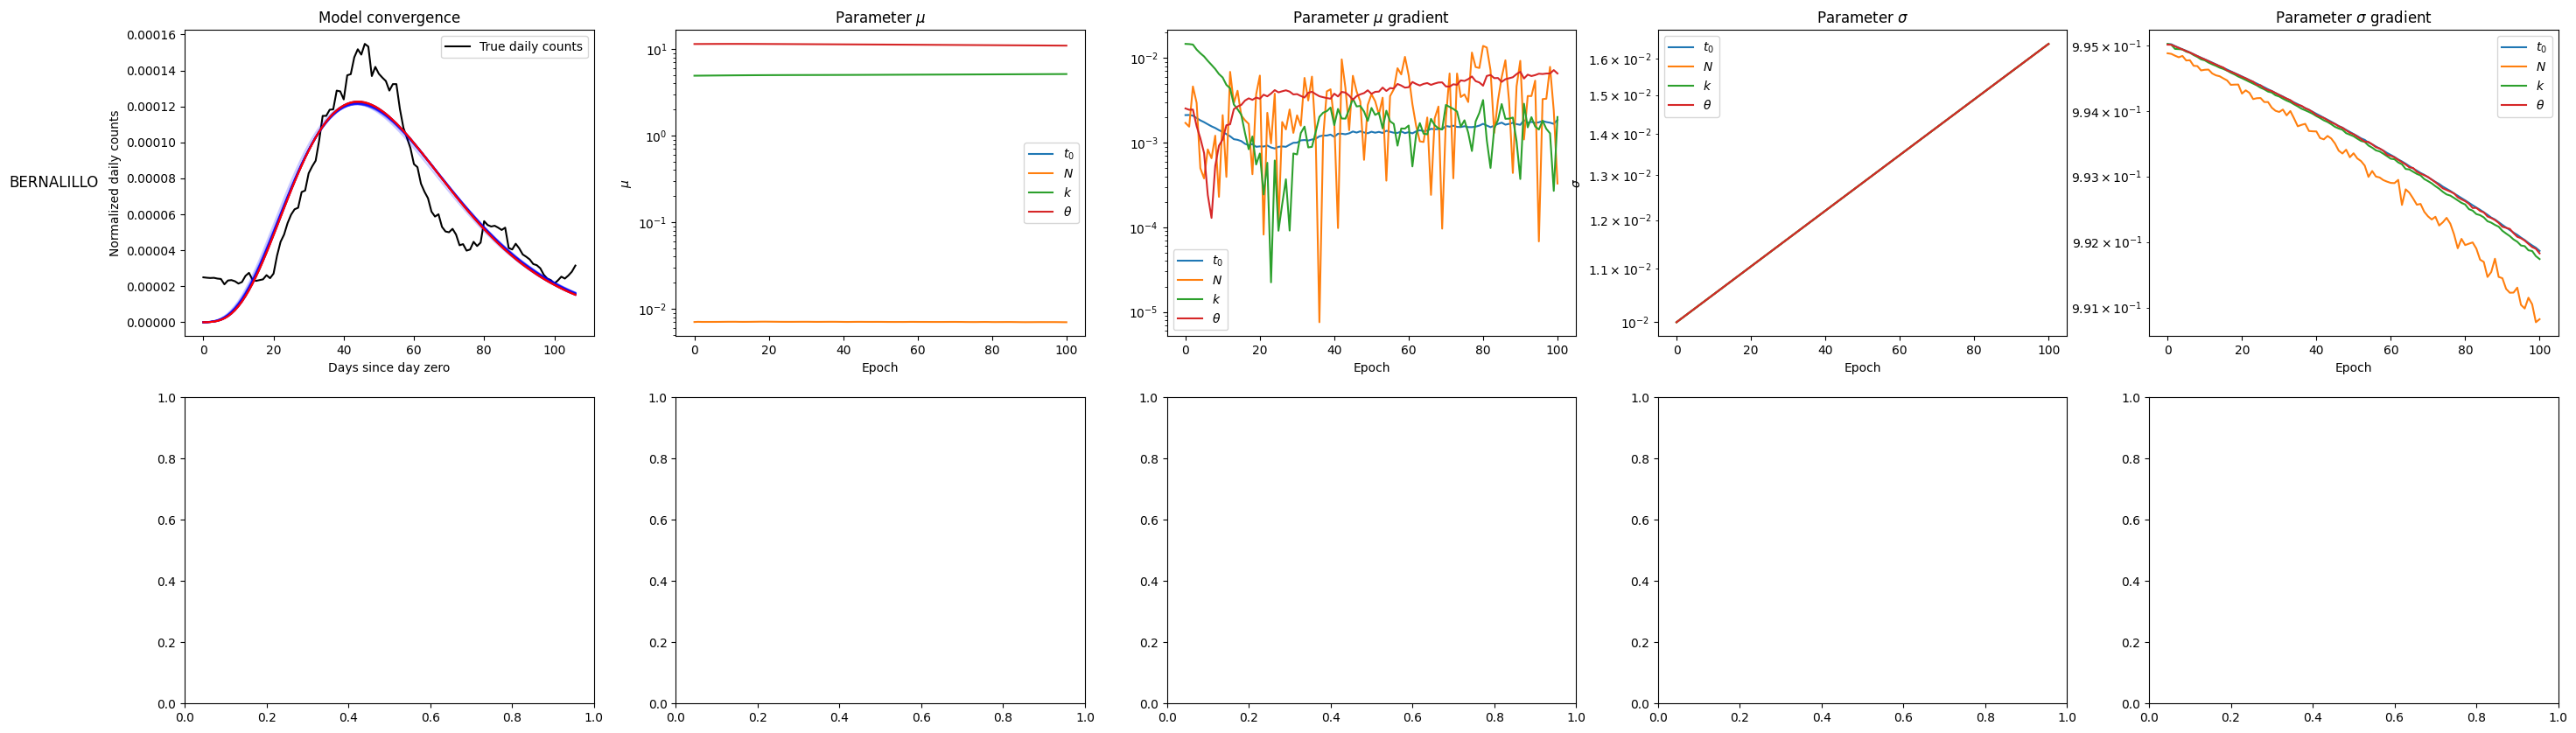

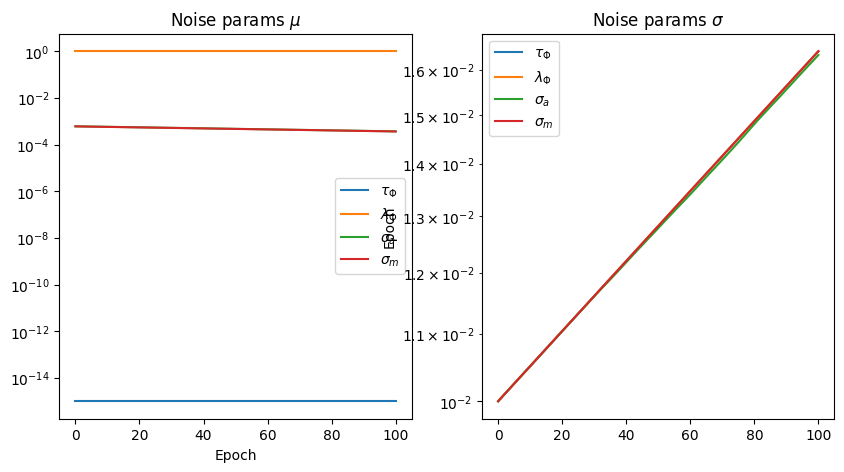

<Figure size 640x480 with 0 Axes>

In [7]:
# Warmstart IC
theta_vec_hist = np.load('{h}theta_hist.npy'.format(h=params['MLE_log_header']))
n_epochs = theta_vec_hist.shape[0]
theta_hat_hist = []
theta_hist = []
for i in range(n_epochs):
    theta_i = vec_to_theta(theta_vec_hist[i])
    theta_hat_hist.append(theta_i)
    theta_hist.append(theta_t(theta_i))

warmstart_epoch = -1
phi_0_mu = [np.copy(theta_hat_hist[warmstart_epoch][0]),np.copy(theta_hat_hist[warmstart_epoch][1])]
print('Started VI from MLE epoch: {0}'.format(warmstart_epoch))

sig_vi = 1e-2
phi_0_sig = [sig_vi*np.ones([params['Nreg'],4]),sig_vi*np.ones(4)]
phi_0 = [np.concatenate([np.expand_dims(phi_0_mu[0],axis=2),np.expand_dims(phi_0_sig[0],axis=2)],axis=2),
            np.concatenate([np.expand_dims(phi_0_mu[1],axis=1),np.expand_dims(phi_0_sig[1],axis=1)],axis=1)]
phi_hat_0 = phi_to_phi_hat(phi_0)

def alpha_schedule(it,max_its):
    return params['VI_alpha_0']

ray.init(runtime_env={"working_dir": '../../../src/'})

# VI via Adam & reparametrization
phi_hat_f,obj_hist,phi_hat_hist, grad_norm_hist = adam_VI(  phi_hat_0=phi_to_vec(phi_hat_0),
                                                            params=params,
                                                            max_its=params['VI_max_its'],
                                                            tol=params['VI_tol'],
                                                            alpha_0=params['VI_alpha_0'],
                                                            alpha_schedule=alpha_schedule,
                                                            log_freq=params['VI_log_freq'],
                                                            log_header=params['VI_log_header'],
                                                            Ns_grad=params['VI_Ns_grad'],
                                                            Ns_obj=params['VI_Ns_obj'])


evaluate_VI(params=params)